<a href="https://colab.research.google.com/github/Justinezgh/SBI-Diff-Simulator/blob/u%2FJustinezgh%2FLensingTask/notebooks/LensingForwardModelLogNormal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Author: Francois Lanusse

In [ ]:
!pip install --quiet lenstools
!pip install --quiet git+https://github.com/DifferentiableUniverseInitiative/jax_cosmo.git 
!pip install --quiet numpyro

     |████████████████████████████████| 259 kB 5.1 MB/s 
     |████████████████████████████████| 292 kB 5.1 MB/s 


In [ ]:
# Retrieving log normal parameters
!wget https://gist.githubusercontent.com/EiffL/071e11f7054ee918c18d0f8ad93085c6/raw/a4c830f03fa7baf3b34729bd8b8c51dccf0eae25/lognormal_shift.csv

--2022-10-05 11:57:51--  https://gist.githubusercontent.com/EiffL/071e11f7054ee918c18d0f8ad93085c6/raw/a4c830f03fa7baf3b34729bd8b8c51dccf0eae25/lognormal_shift.csv
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to gist.githubusercontent.com (gist.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2715 (2.7K) [text/plain]
Saving to: ‘lognormal_shift.csv’

lognormal_shift.csv 100%[===================>]   2.65K  --.-KB/s    in 0s      

2022-10-05 11:57:51 (56.2 MB/s) - ‘lognormal_shift.csv’ saved [2715/2715]



In [ ]:
%pylab inline
import jax
import jax.numpy as jnp
import jax_cosmo as jc

import numpyro
from numpyro.handlers import seed, trace, condition
import numpyro.distributions as dist

import tensorflow_probability as tfp; tfp = tfp.substrates.jax
tfd= tfp.distributions

import logging
logger = logging.getLogger()
class CheckTypesFilter(logging.Filter):
    def filter(self, record):
        return "check_types" not in record.getMessage()
logger.addFilter(CheckTypesFilter())

Populating the interactive namespace from numpy and matplotlib


In [ ]:
lognormal_params = np.loadtxt('lognormal_shift.csv', skiprows=1, delimiter=',').reshape([8,8,3])

Text(0, 0.5, 'sigma_8')

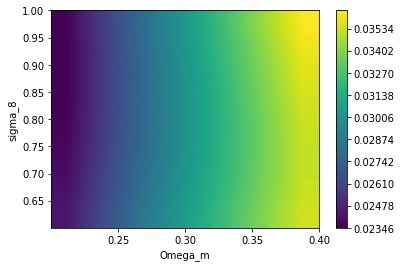

In [ ]:
from jax.scipy.ndimage import map_coordinates

omega_c, sigma8 = np.meshgrid(jnp.linspace(0.2,0.4), jnp.linspace(0.6,1.0))

contourf(omega_c,sigma8, map_coordinates(lognormal_params[:,:,2], 
                                         jnp.stack([(omega_c - 0.2) / 0.2*8 - 0.5, 
                                                    (sigma8 - 0.6) / 0.4*8 - 0.5], axis=0).reshape([2,-1]) , order=1, mode='nearest').reshape(50,50),
         256)
colorbar();
xlabel('Omega_m')
ylabel('sigma_8')

In [ ]:
# Here we add the code that interpolates the shift parameters as a function of cosmology
@jax.jit
def shift_fn(omega_m, sigma_8):
  omega_m = jnp.atleast_1d(omega_m)
  sigma_8 = jnp.atleast_1d(sigma_8) 
  return map_coordinates(lognormal_params[:,:,2], jnp.stack([(omega_m - 0.2) / 0.2*8 - 0.5,
                                                             (sigma_8 - 0.6) / 0.4*8 - 0.5], 
                                                            axis=0).reshape([2,-1]) , order=1, mode='nearest').squeeze()

In [ ]:
shift_fn(0.3, 0.8)

DeviceArray(0.02999174, dtype=float32)

In [ ]:
def make_power_map(pk_fn, N, field_size, zero_freq_val=0.0):
  k = 2*jnp.pi*jnp.fft.fftfreq(N, d=field_size / N)
  kcoords = jnp.meshgrid(k,k)
  k = jnp.sqrt(kcoords[0]**2 + kcoords[1]**2)
  ps_map = pk_fn(k)
  ps_map = ps_map.at[0,0].set(zero_freq_val)
  return ps_map * (N / field_size)**2

def make_lognormal_power_map(power_map, shift, zero_freq_val=0.0):
  power_spectrum_for_lognorm = jnp.fft.ifft2(power_map).real
  power_spectrum_for_lognorm = jnp.log(1 + power_spectrum_for_lognorm/shift**2)
  power_spectrum_for_lognorm = jnp.abs(jnp.fft.fft2(power_spectrum_for_lognorm))
  power_spectrum_for_lognorm = power_spectrum_for_lognorm.at[0,0].set(0.)
  return power_spectrum_for_lognorm

def model(N=128,               # number of pixels on the map
          map_size=5,         # map size in deg.
          gal_per_arcmin2=30,   
          sigma_e=0.2,
          model_type='lognormal'): # either 'lognormal' or 'gaussian'      
    
    pix_area = (map_size * 60 / N)**2 # arcmin2 
    map_size = map_size / 180 * jnp.pi    # radians

    # Sampling cosmology
    omega_c = numpyro.sample('omega_c', dist.Normal(0., 1.0)) * 0.05 + 0.3
    sigma_8 = numpyro.sample('sigma_8', dist.Normal(0., 1.0)) * 0.05 + 0.8
    
    cosmo = jc.Planck15(Omega_c=omega_c, sigma8=sigma_8)
    # Creating a given redshift distribution
    pz = jc.redshift.smail_nz(0.5, 2., 1.0)
    tracer = jc.probes.WeakLensing([pz])
    
    # Defining the function that will compute the power spectrum of the field
    # Create an interpolation array for the cls to avoid far too many computations
    ell_tab = jnp.logspace(0, 4.5, 128)
    cell_tab = jc.angular_cl.angular_cl(cosmo, ell_tab, [tracer])[0]
    P = lambda k: jc.scipy.interpolate.interp(k.flatten(), ell_tab, cell_tab).reshape(k.shape)
    
    # Sampling latent variables
    z = numpyro.sample('z', dist.MultivariateNormal(loc=jnp.zeros((N,N)), precision_matrix=jnp.eye(N)))

    # Convolving by the power spectrum
    power_map = make_power_map(P, N, map_size) 
    if model_type == 'lognormal':
      # Compute the shift parameter as a function of cosmology
      shift = shift_fn(cosmo.Omega_m, sigma_8)
      power_map =  make_lognormal_power_map(power_map, shift)

    field = jnp.fft.ifft2(jnp.fft.fft2(z) * jnp.sqrt(power_map)).real

    if model_type == 'lognormal':
      field = shift * (jnp.exp(field - jnp.var(field) / 2) - 1)

    # Adding "observational noise"
    x = numpyro.sample('x', dist.Independent(dist.Normal(field, sigma_e/jnp.sqrt(gal_per_arcmin2 * pix_area)), 2))
    
    return x

In [ ]:
# Create our fiducial observations
fiducial_model = condition(model, {'omega_c': 0., 'sigma_8': 0.})
sample_map_fiducial = seed(fiducial_model, jax.random.PRNGKey(42))
m_data = sample_map_fiducial()

/usr/local/lib/python3.7/dist-packages/jax_cosmo/scipy/interpolate.py:35: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  s = np.sign(np.clip(x, xp[1], xp[-2]) - xi).astype(np.int64)
/usr/local/lib/python3.7/dist-packages/jax_cosmo/scipy/interpolate.py:36: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  a = (fp[ind + np.copysign(1, s).astype(np.int64)] - fp[ind]) / (
/usr/local/lib/python3.7/dist-packages/jax_cosmo/scipy/interpolate.py:37: UserWarnin

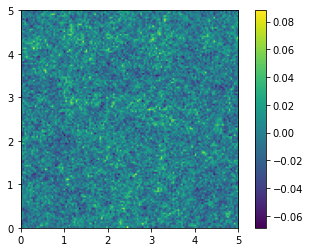

In [ ]:
imshow(m_data, extent=(0,5,0,5))
colorbar()

/usr/local/lib/python3.7/dist-packages/jax_cosmo/scipy/interpolate.py:35: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  s = np.sign(np.clip(x, xp[1], xp[-2]) - xi).astype(np.int64)
/usr/local/lib/python3.7/dist-packages/jax_cosmo/scipy/interpolate.py:36: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  a = (fp[ind + np.copysign(1, s).astype(np.int64)] - fp[ind]) / (
/usr/local/lib/python3.7/dist-packages/jax_cosmo/scipy/interpolate.py:37: UserWarnin

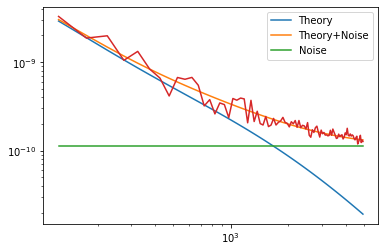

In [ ]:
# Checking that the power spectrum looks ok with Lenstools
import lenstools as lt
import astropy.units as u

cosmo = jc.Planck15(Omega_c=0.3, sigma8=0.8)
# Creating a given redshift distribution
pz = jc.redshift.smail_nz(0.5, 2., 1.0,gals_per_arcmin2=30.)
tracer = jc.probes.WeakLensing([pz], sigma_e=0.2)
f_sky= 5**2/41_253

kmap_lt = lt.ConvergenceMap(m_data, 5*u.deg)
l_edges = np.arange(100.0,5000.0,50.0)
l2,Pl2 = kmap_lt.powerSpectrum(l_edges)

cell = jc.angular_cl.angular_cl(cosmo, l2, [tracer])[0]
cell_noise = jc.angular_cl.noise_cl(l2, [tracer])[0]
_, C = jc.angular_cl.gaussian_cl_covariance_and_mean(cosmo, l2, [tracer], f_sky=f_sky)

loglog(l2, cell, label='Theory')
loglog(l2, cell + cell_noise, label='Theory+Noise')
loglog(l2, cell_noise, label='Noise')
loglog(l2, Pl2 )
legend()

In [ ]:
# ok, perfect, so we can write our likelihood function
@jax.jit
@jax.vmap
def log_prob_fn(params):
  cosmo = jc.Planck15(Omega_c=params[0]* 0.05 + 0.3, 
                      sigma8=params[1]* 0.05 + 0.8)
  cell = jc.angular_cl.angular_cl(cosmo, l2, [tracer])[0]
  return tfd.MultivariateNormalDiag(cell,scale_diag=jnp.sqrt(np.diag(C))).log_prob(Pl2-cell_noise) + tfd.MultivariateNormalDiag(loc=jnp.zeros(2), scale_identity_multiplier=1.).log_prob(params)

In [ ]:
# Initialize the HMC transition kernel.
num_results = int(1e3)
num_burnin_steps = int(1e2)
adaptive_hmc = tfp.mcmc.SimpleStepSizeAdaptation(
    tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn=log_prob_fn,
        num_leapfrog_steps=3,
        step_size=0.07),
    num_adaptation_steps=int(num_burnin_steps * 0.8))

# Run the chain (with burn-in).
samples, is_accepted = tfp.mcmc.sample_chain(
      num_results=num_results,
      num_burnin_steps=num_burnin_steps,
      current_state=randn(32, 2),
      kernel=adaptive_hmc,
      trace_fn=lambda _, pkr: pkr.inner_results.is_accepted,
      seed=jax.random.PRNGKey(0))

/usr/local/lib/python3.7/dist-packages/tensorflow_probability/python/internal/backend/jax/ops.py:273: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return arr.astype(dtype)
/usr/local/lib/python3.7/dist-packages/jax_cosmo/scipy/interpolate.py:35: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  s = np.sign(np.clip(x, xp[1], xp[-2]) - xi).astype(np.int64)
/usr/local/lib/python3.7/dist-packages/jax_cosmo/scipy/interpolate.py:36: UserWarning: Explicitly requested dtyp

In [ ]:
mean(is_accepted)

DeviceArray(0.8863438, dtype=float32)

In [ ]:
samples = samples[is_accepted]

(0.6, 1.0)

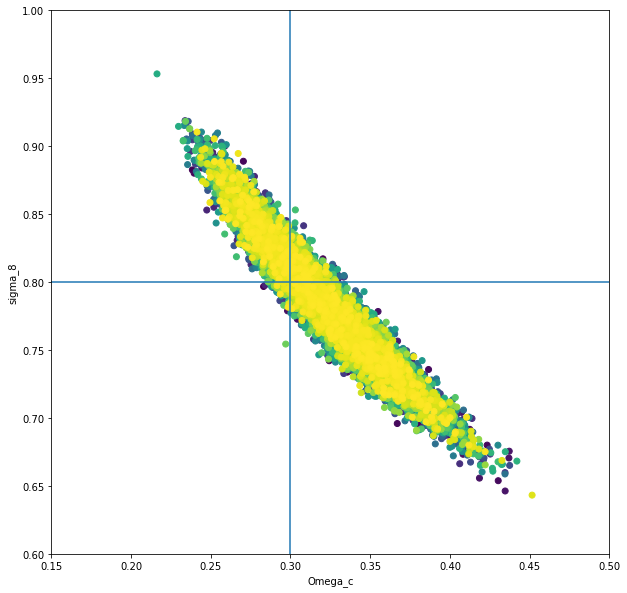

In [ ]:
figure(figsize=[10,10])
scatter(samples[:,0]* 0.05 + 0.3, samples[:,1]* 0.05 + 0.8, c=arange(len(samples)));
axvline(0.3)
axhline(0.8)
xlabel('Omega_c')
ylabel('sigma_8')
xlim(0.15,0.5)
ylim(0.6,1.)

In [ ]:
with open('samples.npy','wb') as f:
  save(f, samples)

In [ ]:
with open('map.npy','wb') as f:
  save(f, m_data)

## Try to run an MCMC chain on this model

In [ ]:
# Now we condition the model on obervations
observed_model = condition(model, {'x': m_data})

In [ ]:
nuts_kernel = numpyro.infer.NUTS(observed_model,
                                 init_strategy=numpyro.infer.init_to_median,
                                 max_tree_depth=6,
                                 step_size=0.02)

In [ ]:
mcmc = numpyro.infer.MCMC(nuts_kernel, 
                          num_warmup=100, 
                          num_samples=1000)

In [ ]:
mcmc.run(jax.random.PRNGKey(3))

/usr/local/lib/python3.7/dist-packages/jax_cosmo/scipy/interpolate.py:35: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  s = np.sign(np.clip(x, xp[1], xp[-2]) - xi).astype(np.int64)
/usr/local/lib/python3.7/dist-packages/jax_cosmo/scipy/interpolate.py:36: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  a = (fp[ind + np.copysign(1, s).astype(np.int64)] - fp[ind]) / (
/usr/local/lib/python3.7/dist-packages/jax_cosmo/scipy/interpolate.py:37: UserWarnin

In [ ]:
res = mcmc.get_samples()

In [ ]:
# Saving the trace
import pickle

with open('lensing_fwd_mdl_lognorm.pickle', 'wb') as handle:
    pickle.dump(res, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
from google.colab import files
files.download('lensing_fwd_mdl_lognorm.pickle')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

(0.6, 1.0)

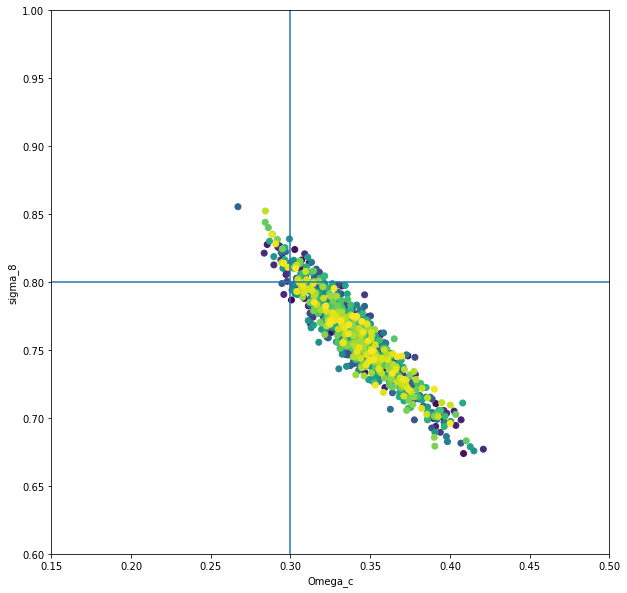

In [ ]:
figure(figsize=[10,10])
scatter(res['omega_c']* 0.05 + 0.3, res['sigma_8']* 0.05 + 0.8, c=arange(len(res['sigma_8'])));
axvline(0.3)
axhline(0.8)
xlabel('Omega_c')
ylabel('sigma_8')
xlim(0.15,0.5)
ylim(0.6,1.)

In [ ]:
!pip install chainconsumer

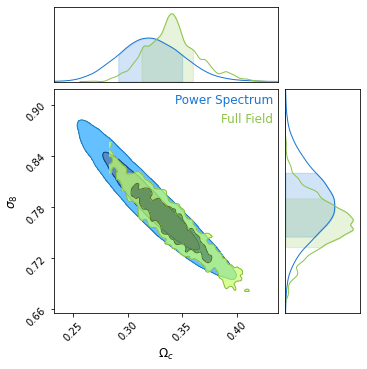

In [ ]:
from chainconsumer import ChainConsumer

c = ChainConsumer()
c.add_chain(samples* 0.05 + np.array([0.3,0.8]), parameters=["$\Omega_c$", "$\sigma_8$"], name='Power Spectrum')
c.add_chain(np.stack([res['omega_c']* 0.05 + 0.3, res['sigma_8']* 0.05 + 0.8],axis=1), parameters=["$\Omega_c$", "$\sigma_8$"], name='Full Field')
fig = c.plotter.plot(figsize="column")

Let's try to look at posterior samples of the maps

In [ ]:
@jax.jit
def get_map(oc,s8,z):
  cond_model = condition(model, {'omega_c': oc, 'sigma_8': s8, 'z':z})
  sample_map_cond = seed(cond_model, jax.random.PRNGKey(42))
  return sample_map_cond(sigma_e=0.)

In [ ]:
len(res['z'])

1000

In [ ]:
maps = []
for i in range(1000):
  m = get_map(res['omega_c'][i],
              res['sigma_8'][i], 
              res['z'][i])
  maps.append(m)

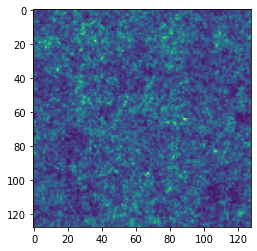

In [ ]:
imshow(maps[-1])

In [ ]:
# The following is borrowed from https://github.com/ericjang/nf-jax/blob/master/nf-tutorial-jax.ipynb
from matplotlib import animation, rc
# from IPython.display import HTML, Image
# equivalent to rcParams['animation.html'] = 'html5'
rc('animation', html='html5')

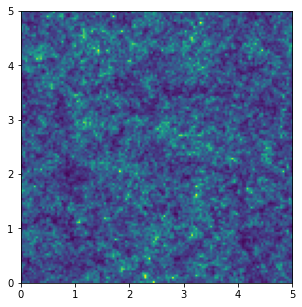

In [ ]:
fig = plt.figure(figsize=[5,5])

im = imshow(maps[0], extent=[0,5,0,5])

def animate(i):
  im.set_array(maps[i*10])
  return (im,)

anim = animation.FuncAnimation(fig, animate, frames=100, interval=100, blit=False)

In [ ]:
anim

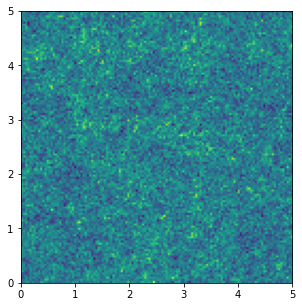

In [ ]:
fig = plt.figure(figsize=[5,5])
imshow(m_data, extent=[0,5,0,5])